In [2]:
import limbo
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import time
from scipy.ndimage import maximum_filter1d

%matplotlib inline
# %matplotlib notebook

In [3]:
# filename = os.environ['LIMBO_PROCFILE']
filename = '../../../limbo_data/data/Spectra_20230321100722.dat'
# filename = '/home/obs/data/save/Spectra_20230320170204.dat'
# filename = '../../../data/save/Spectra_20230320170204.dat'
INJECT_FRB = int(os.environ.get('LIMBO_INJECT_FRB', '0'))
NSIG = int(os.environ.get('LIMBO_NSIG', '6'))
MAX_DM = int(os.environ.get('LIMBO_MAX_DM', '500'))
EXCLUDE_S = float(os.environ.get('LIMBO_EXCLUDE_S', '0.05'))
REMOVE_DIR = os.environ.get('LIMBO_REMOVE_DIR', None)
SAVE_DIR = os.environ.get('LIMBO_SAVE_DIR', None)
CH0, CH1 = 400, 400+1024

print('Processing:', filename)
print('INJECT_FRB:', INJECT_FRB)
print('NSIG:', NSIG)
print('MAX_DM:', MAX_DM)
print('EXCLUDE_S:', EXCLUDE_S)
print('REMOVE_DIR:', REMOVE_DIR)
print('SAVE_DIR:', SAVE_DIR)

Processing: ../../../limbo_data/data/Spectra_20230321100722.dat
INJECT_FRB: 0
NSIG: 6
MAX_DM: 500
EXCLUDE_S: 0.05
REMOVE_DIR: None
SAVE_DIR: None


In [4]:
hdr = limbo.io.read_header(filename)
print('Observed:', time.ctime(hdr['Time']))
for k, v in hdr.items():
    print(f'    {k:15s}: {v}')
assert hdr['nspec'] == 4096
ker = int(np.around(EXCLUDE_S / hdr['inttime']))
print(f'ker={ker}')

Observed: Tue Mar 21 03:07:22 2023
    SWVer          : 0.0.1
    fpg            : limbo_500_2022-12-03_1749.fpg
    Time           : 1679393242.111212
    AccLen         : 127
    AdcCoarseGain  : 4
    FFTShift       : 2047
    DataSel        : 1
    Scaling        : 0
    SpecCoeff      : 4
    AdcDelay0      : 5
    AdcDelay1      : 5
    AdcDelay2      : 5
    AdcDelay3      : 5
    AdcDelay4      : 5
    AdcDelay5      : 5
    AdcDelay6      : 5
    AdcDelay7      : 5
    RF_Lo_Hz       : 1350000000
    Target_RA_Deg  : 19h34m55.598s
    Target_DEC_Deg : +21d53m47.79s
    Pointing_AZ    : 74.81
    Pointing_EL    : 16.6
    Pointing_Updated: 1679393236.249036
    filename       : ../../../limbo_data/data/Spectra_20230321100722.dat
    sample_clock   : 500000000.0
    freqs          : [1.35000000e+09 1.35012207e+09 1.35024414e+09 ... 1.59963379e+09
 1.59975586e+09 1.59987793e+09]
    inttime        : 0.001040384
    nspec          : 4096
ker=48


In [5]:
class Summary:
    
    def __init__(self):
        self.clear()
    
    def clear(self):
        self.dms = {
            (0  ,100): [],
            (100,200): [],
            (200,300): [],
            (300,400): [],
            (400,500): [],
            (500,1000): [],
            (1000,2000): [],
            (2000,3000): [],
            (3000,4000): [],
        }
        self.avg_spec = []
        self.gain_vs_t = []
    
    def add_summary(self, summary):
        dm_vs_t = summary['dmt']
        dms = summary['dms']
        for (lo, hi) in self.dms.keys():
            try:
                self.dms[lo, hi].append(np.max(dm_vs_t[:,np.logical_and(hi > dms, dms >= lo)], axis=1))
            except(ValueError):
                pass
    
    def get_summary(self):
        rv = {}
        for k, v in self.dms.items():
            try:
                rv[k] = np.concatenate(v)
            except(ValueError):
                pass
        return rv
    
    def get_events(self, ker, nsig, summary=None, in_keys=[(300,400)], out_keys=[(0,100),(100,200)],
                   verbose=True):
        if summary is None:
            summary = self.get_summary()
            
        events = {}
        for k, v in summary.items():
            if type(k) == str:
                continue
            avg = np.median(v)
            sig = np.median(np.abs(v - avg))
            zscore = (v - avg) / sig
            if verbose:
                print(f'DM={k}: avg={avg:7.2f} +/- {sig:7.2f}')
            events[k] = zscore
            
        events['out'] = np.array([events[k] for k in out_keys]).max(axis=0)
        events['in'] = np.array([events[k] for k in in_keys]).max(axis=0)
        # Use worst case scenarios to shift the kernal
        delay0 = limbo.fdmt.DM_delay(0, hdr['freqs'][0])
        delayf = limbo.fdmt.DM_delay(100, hdr['freqs'][0])
        Delta = int(np.around((delay0-delayf) / hdr['inttime']) / 2) # by definition Delta < 0
        _size = ker + abs(Delta)
        _roll_amt = int(np.around(Delta / 2))
        events['thresh'] = np.roll(maximum_filter1d(events['out'], size=_size, mode='nearest').clip(nsig, np.Inf),
                                   _roll_amt)
        events['interesting'] = (events['in'] > events['thresh'])
        return events

In [6]:
# Process the data
hdr, data = limbo.io.read_file(filename, nspec=-1)
dts = hdr['times'] - hdr['times'][0]

calgain = limbo.processing.CALGAIN # gain to convert to Jys

if INJECT_FRB:
    sim_frb = limbo.sim.make_frb(hdr['times'], hdr['freqs'], DM=331,
                                 pulse_width=0.12e-3, pulse_amp=50, t0=hdr['times'][3000])
    sim_frb *= (limbo.processing.FMDL / limbo.processing.FMDL.max())
    data = data + sim_frb
    
dmt = limbo.processing.process_data(hdr, data, maxdm=MAX_DM)
fmdl = dmt['fmdl']

# Add Gaussian noise to masked channels
nos = fmdl / hdr['AccLen']**0.5
noise = np.random.normal(loc=0, scale=abs(nos), size=dmt['diff'].shape)

summary = Summary()
summary.add_summary(dmt)
report = summary.get_summary()
events = summary.get_events(ker, NSIG, summary=report)
interesting = np.any(events['interesting'])

DM=(0, 100): avg=2987.44 +/-  442.28
DM=(100, 200): avg=3113.11 +/-  450.65
DM=(200, 300): avg=3133.89 +/-  482.62
DM=(300, 400): avg=3142.81 +/-  483.35
DM=(400, 500): avg=3097.68 +/-  455.03


In [7]:
### STAGE 1: Look for all events above threshold.
print(f"DMs: {dmt['dms'][0]} -- {dmt['dms'][-1]}")
for k, v in events.items():
    if k == 'interesting':
        print(f'{k}: {(v > 0).sum()} event(s)')
    elif type(k) is tuple:
        event_ts = (v > events['thresh'])
        nevents = event_ts.sum()
        print(f'{k}: {nevents} event(s)', end='')
        if nevents > 0:
            ki = np.searchsorted(dmt['dms'], k[0])
            kj = np.searchsorted(dmt['dms'], k[1])
            inds = np.argmax(dmt['dmt'][event_ts, ki:kj], axis=1)
            print(f', nsig_max={v[v > events["thresh"]].max():3.1f}, dms={dmt["dms"][ki:kj][inds]}')
        else:
            print()
print('\nAnything Interesting:', interesting)

DMs: 0.0 -- 499.51171875
(0, 100): 0 event(s)
(100, 200): 0 event(s)
(200, 300): 2 event(s), nsig_max=6.9, dms=[260.25390625 288.57421875]
(300, 400): 1 event(s), nsig_max=8.3, dms=[329.58984375]
(400, 500): 5 event(s), nsig_max=6.6, dms=[403.80859375 493.65234375 427.24609375 468.26171875 486.81640625]
interesting: 1 event(s)

Anything Interesting: True


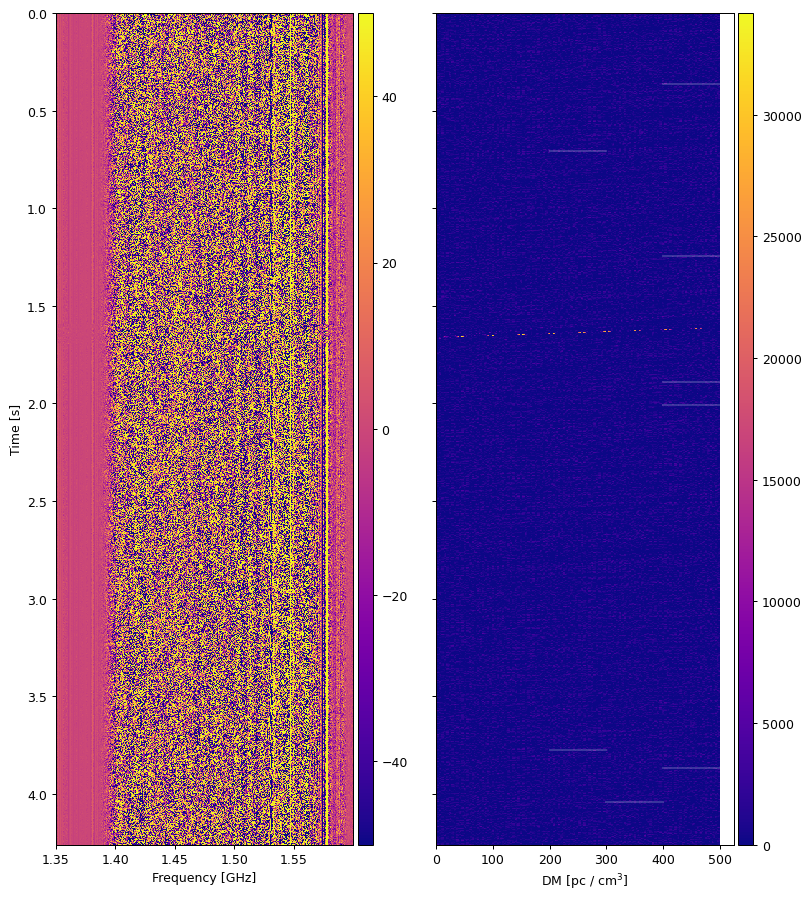

In [8]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 12), dpi=90)

scale = 50
im0 = axes[0].imshow(np.where(dmt['diff'] == 0, noise, dmt['diff']),
               extent=(hdr['freqs'][0] / 1e9, hdr['freqs'][-1] / 1e9, dts[-1], dts[0]),
               cmap='plasma', vmax=scale, vmin=-scale, interpolation='nearest', aspect='auto')
im1 = axes[1].imshow(dmt['dmt'], cmap='plasma', vmin=0,
               extent=(dmt['dms'][0], dmt['dms'][-1], dts[-1], dts[0]),
               interpolation='nearest', aspect='auto')
for k, v in events.items():
    if type(k) is str:
        continue
    for t in dts[v > events['thresh']]:
        axes[1].plot(k, (t, t), 'w', alpha=0.2)
axes[0].set_xlabel('Frequency [GHz]')
axes[1].set_xlabel('DM [pc / cm$^3$]')
axes[0].set_ylabel('Time [s]')
cax = make_axes_locatable(axes[0]).append_axes('right', size='5%', pad=0.05)
_ = plt.colorbar(im0, cax=cax)
cax = make_axes_locatable(axes[1]).append_axes('right', size='5%', pad=0.05)
_ = plt.colorbar(im1, cax=cax)

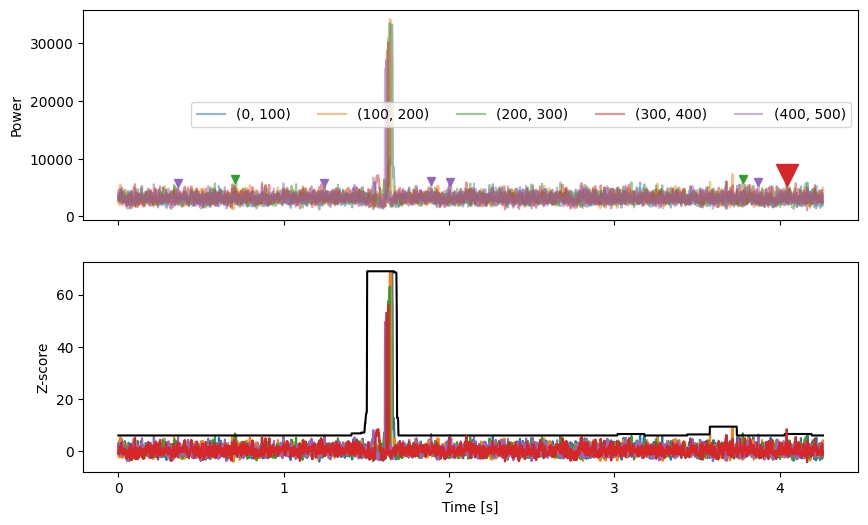

In [9]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))
colors = {}
for k, v in events.items():
    if type(k) == str:
        continue
    line, = axes[0].plot(dts, report[k], label=k, alpha=0.5)
    colors[k] = line.get_color()
    axes[0].plot(dts[v > events['thresh']], report[k][v > events['thresh']], 'v', color=line.get_color())
    axes[1].plot(dts, v, color=colors[k])
    
k = (300, 400)
v = events[k]
axes[0].plot(dts[events['interesting'] & (v > events['thresh'])], 
             report[k][events['interesting'] & (v > events['thresh'])], 
             'v', color=colors[k], markersize=16)
#axes[1].plot(dts, maximum_filter1d(events['out'], size=ker, mode='nearest'))
axes[1].plot(dts, events['thresh'], 'k')
axes[1].plot(dts, events['in'], color=colors[k])
axes[1].set_xlabel('Time [s]')
axes[0].set_ylabel('Power')
axes[1].set_ylabel('Z-score')
_ = axes[0].legend(ncol=5)

In [10]:
### STAGE 2: For all 300-400 DM events de-disperse them to DM of SGR1935+2154. 
## Keep only those that can be de-dispersed to that DM.
if interesting:
    cal_data = dmt['diff']*calgain
    k = (300, 400)
    DM = 332.7
    t_events = [(evt, nsig) for evt, nsig in zip(dts[events[k] > events['thresh']], 
                                                 events[k][events[k] > events['thresh']])]
    delays = limbo.sim.DM_delay(DM, hdr['freqs'])
    delays -= delays[-1]  # center lowest delay at t0
    _pulse = np.fft.rfft(cal_data, axis=0)
    _ffreq = np.fft.rfftfreq(cal_data.shape[0], hdr['times'][1] - hdr['times'][0])
    phs = np.exp(2j * np.pi * np.outer(_ffreq, delays))  # sign reversed to de-disperse
    _pulse_dly = _pulse * phs
    ans = np.fft.irfft(_pulse_dly, axis=0)

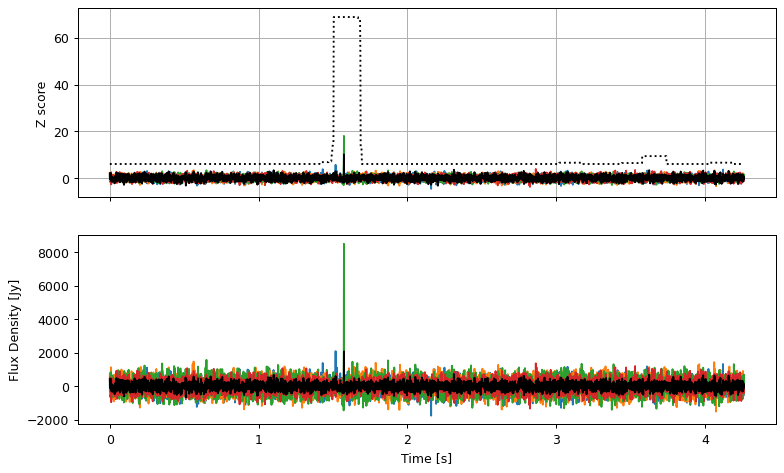

In [11]:
if interesting:
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 6), dpi=90)
    ans2 = np.mean(ans[:, CH0:CH1].reshape(ans.shape[0], -1, 256), axis=-1)
    ans3 = np.mean(ans[:, CH0:CH1], axis=-1)
    zscore3 = (ans3 - np.mean(ans3)) / np.std(ans3)
    axes[0].plot(dts, (ans2 - np.mean(ans2, axis=0, keepdims=True)) / np.std(ans2, axis=0, keepdims=True))
    axes[0].plot(dts, (ans3 - np.mean(ans3)) / np.std(ans3), 'k')
    axes[0].plot(dts, events['thresh'], 'k:')
    axes[1].plot(dts, ans2)
    axes[1].plot(dts, ans3, 'k')
    axes[1].set_xlabel('Time [s]')
    axes[0].set_ylabel('Z score')
    axes[0].grid()
    axes[1].set_ylabel('Flux Density [Jy]')

In [12]:
### STAGE 3: Of the surviving events, determine if their de-dispersed z-scores are above a threshold.
save_file = False
if interesting:
    tind_events = np.where(zscore3 > events['thresh'])[0]
    if tind_events.size > 0:
        zmax = np.max(zscore3[tind_events])
        print(f'De-dispersed Z-score: {zmax:4.1f}')
        save_file = True

In [13]:
if save_file:
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 12), dpi=90)

    scale = 5000
    im0 = axes[0].imshow(np.where(cal_data == 0, noise*calgain, cal_data),
                   extent=(hdr['freqs'][0] / 1e9, hdr['freqs'][-1] / 1e9, dts[-1], dts[0]),
                   cmap='plasma', vmax=scale, vmin=-scale, interpolation='nearest', aspect='auto')
    im1 = axes[1].imshow(np.where(ans == 0, noise*calgain, ans),
                   extent=(hdr['freqs'][0] / 1e9, hdr['freqs'][-1] / 1e9, dts[-1], dts[0]),
                   cmap='plasma', vmax=scale, vmin=-scale, interpolation='nearest', aspect='auto')
    for event in tind_events:
        t = event * hdr['inttime']
        axes[0].plot(hdr['freqs'] / 1e9, t + delays - delays[1420], 'k', alpha=0.5)
    axes[0].set_xlabel('Frequency [GHz]')
    axes[1].set_xlabel('Frequency [GHz]')
    axes[0].set_title(f'Diff Data')
    axes[1].set_title(f'De-dispersed to DM={DM:3.1f}')
    axes[0].set_ylabel('Time [s]')
    cax = make_axes_locatable(axes[0]).append_axes('right', size='5%', pad=0.05)
    _ = plt.colorbar(im0, cax=cax)
    cax = make_axes_locatable(axes[1]).append_axes('right', size='5%', pad=0.05)
    _ = plt.colorbar(im1, cax=cax)

In [14]:
if save_file:
    plt.figure()
    for i in tind_events:
        plt.plot(hdr['freqs'] / 1e9, np.convolve(ans[i], np.ones((50)), mode='same'))
    # plt.plot(hdr['freqs'] / 1e9, np.convolve(ans[100], np.ones((50)), mode='same'))
    plt.xlabel('Frequency [GHz]')
    plt.ylabel('Flux Density [uncal]')
    plt.show()

In [15]:
print('Save file:', save_file)
if save_file:
    if SAVE_DIR != None:
        outfile = os.path.join(SAVE_DIR, os.path.basename(filename))
        print(f'Moving {filename} -> {outfile}')
        os.rename(filename, outfile)
else:
    if REMOVE_DIR != None:
        outfile = os.path.join(REMOVE_DIR, os.path.basename(filename))
        print(f'Moving {filename} -> {outfile}')
        os.rename(filename, outfile)

Save file: False
